TRANSFER LEARNING

In [1]:
# Importiamo le librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import keras
import os

2023-09-01 11:04:38.654132: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 11:04:39.252605: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 11:04:39.255210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 11:04:43.067337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# importiamo il dataset da google apis
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# definiamo i path per i dati di training e di validation
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# definiamo i parametri di batch e di dimensione delle immagini
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# definiamo i generatori di immagini per il training e la validation
train_dataset = keras.utils.image_dataset_from_directory(train_dir,shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = keras.utils.image_dataset_from_directory(validation_dir,shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


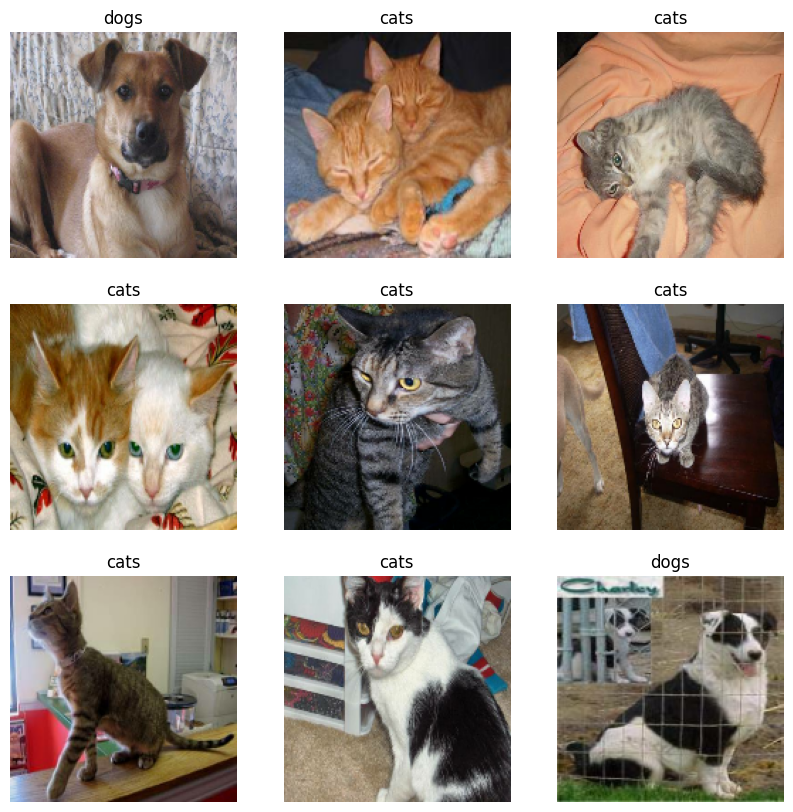

In [3]:
# definiamo le classi del dataset
class_names = train_dataset.class_names

# plottiamo alcune immagini del dataset
plt.figure(figsize=(10, 10), facecolor='white')
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
# dividiamo ora i dataset in training, validation e test
import tensorflow as tf
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

## configuriamo il dataset per migliorare le performance del modello
usiamo il buffered prefetching per caricare le immagini dal disco senza dover attendere che vengano caricate durante l'addestramento del modello

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

# usiamo la cache e il prefetching per velocizzare il training
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Usiamo il data augmentation per aumentare le performance del modello
quando una immagine del dataset e' piccola e' possibile aumentarne la dimensione per migliorare le performance del modello. Applichiamo una realistica trasformazione casuale alle immagini, come flipping e rotazione. Questo aiuta a generalizza layresre meglio e a minimizzare il overfitting.

**NOTA**: questi layers sono attivi solo durante il training, quando il modello in fase evaluation, predict o call non vengono applicati.

In [6]:
data_augmentation = keras.Sequential([keras.layers.RandomFlip("horizontal"),keras.layers.RandomRotation(0.1),]) 

Applichiamo questi layers al dataset

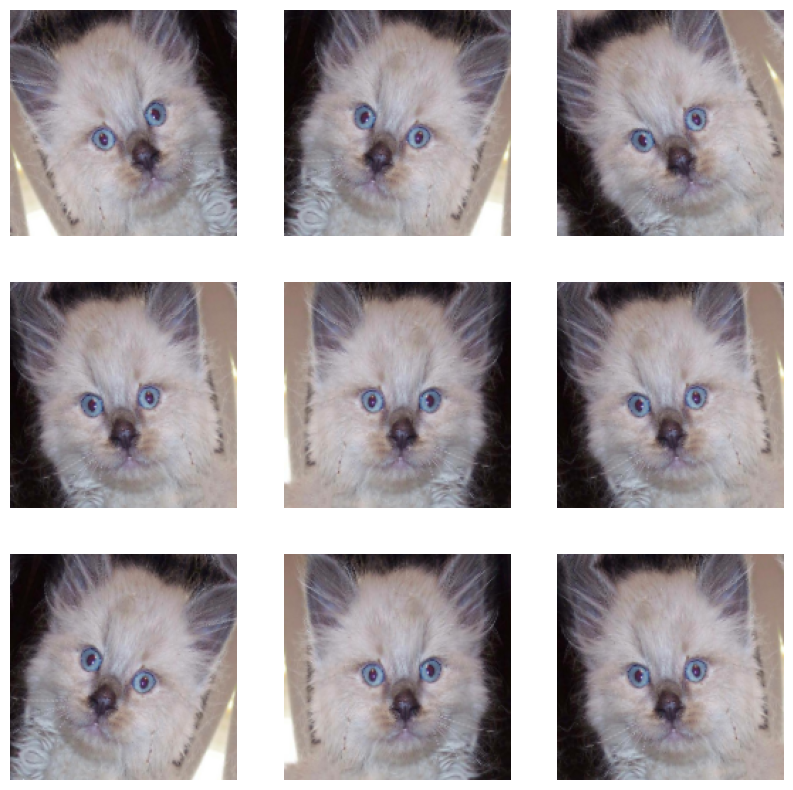

In [7]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10), facecolor='white')
    first_image = image
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image[0], 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')


Riscaliamo le immagini da 0 a 255 a -1 e 1 usando MobileNetV2 preprocessing layer

In [8]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

## Creiamo il modello base dal pre-trained model MobileNet V2

Il modello pre-trained viene caricato con i pesi allenati su ImageNet. Questo e' allenato per riconoscere 1000 classi differenti.


In [9]:
# creiamo il modello base MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

Questa feuature extraction layer converte ogni 160x160x3 immagine in un 5x5x1280 block di features. Vediamo come funziona su un batch di immagini

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-09-01 11:04:58.503281: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2023-09-01 11:04:58.543047: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2023-09-01 11:04:58.617360: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2023-09-01 11:04:58.662395: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80621568 exceeds 10% of free system memory.


(32, 5, 5, 1280)


## Estrazione delle features

In questo step congeliamo il modello base creato in precedenza e lo usiamo come extractor di features, aggiungendo un classificatore su di esso, e addestrando il nuovo classificatore.

## Congelamento del modello base

Congeliamo il modello base per evitare che i pesi vengano aggiornati durante il training

In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

## Aggiungiamo un classificatore su di esso

Dobbiamo aggiungere un classificatore per allenare il modello per classificare le immagini del dataset. Iniziamo con un layer di gloablavarage2D su di esso. Questo layer prende ogni 5x5x1280 features e le converte in un vettore 2D.

In [14]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Creiamo un layer Dense per convertire questi features in una singola prediction per la classe della immagine. 

In [15]:
prediction_layer = keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Mettiamo insieme il modello

Vogliamo mettere in sequenza tutti gli step per creare il modello finale.

In [16]:
input = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(input)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
output = prediction_layer(x)

model = keras.Model(inputs=input, outputs=output)


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

## Compiliamo il modello

In [19]:
base_learning_rate = 0.0001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

## Addestriamo il modello

In [20]:
initila_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

/home/onizuka-host/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-09-01 11:47:46.896293: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.


26/26 [==============================] - 14s 428ms/step - loss: 0.6571 - accuracy: 0.6287


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.63


In [22]:
hystory = model.fit(train_dataset, epochs=initila_epochs, validation_data=validation_dataset)

Epoch 1/10


/home/onizuka-host/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 79s 1s/step - loss: 0.6166 - accuracy: 0.6690 - val_loss: 0.4307 - val_accuracy: 0.8230
Epoch 2/10
63/63 [==============================] - 45s 713ms/step - loss: 0.4484 - accuracy: 0.7985 - val_loss: 0.3140 - val_accuracy: 0.9109
Epoch 3/10
63/63 [==============================] - 45s 708ms/step - loss: 0.3433 - accuracy: 0.8645 - val_loss: 0.2509 - val_accuracy: 0.9332
Epoch 4/10
63/63 [==============================] - 44s 693ms/step - loss: 0.2925 - accuracy: 0.8960 - val_loss: 0.2121 - val_accuracy: 0.9468
Epoch 5/10
63/63 [==============================] - 48s 753ms/step - loss: 0.2486 - accuracy: 0.9125 - val_loss: 0.1816 - val_accuracy: 0.9554
Epoch 6/10
63/63 [==============================] - 48s 752ms/step - loss: 0.2267 - accuracy: 0.9185 - val_loss: 0.1589 - val_accuracy: 0.9579
Epoch 7/10
63/63 [==============================] - 48s 755ms/step - loss: 0.2000 - accuracy: 0.9310 - val_loss: 0.1485 - val_accuracy: 0.9604
Epoch 8/10
63

## Curva di apprendimento

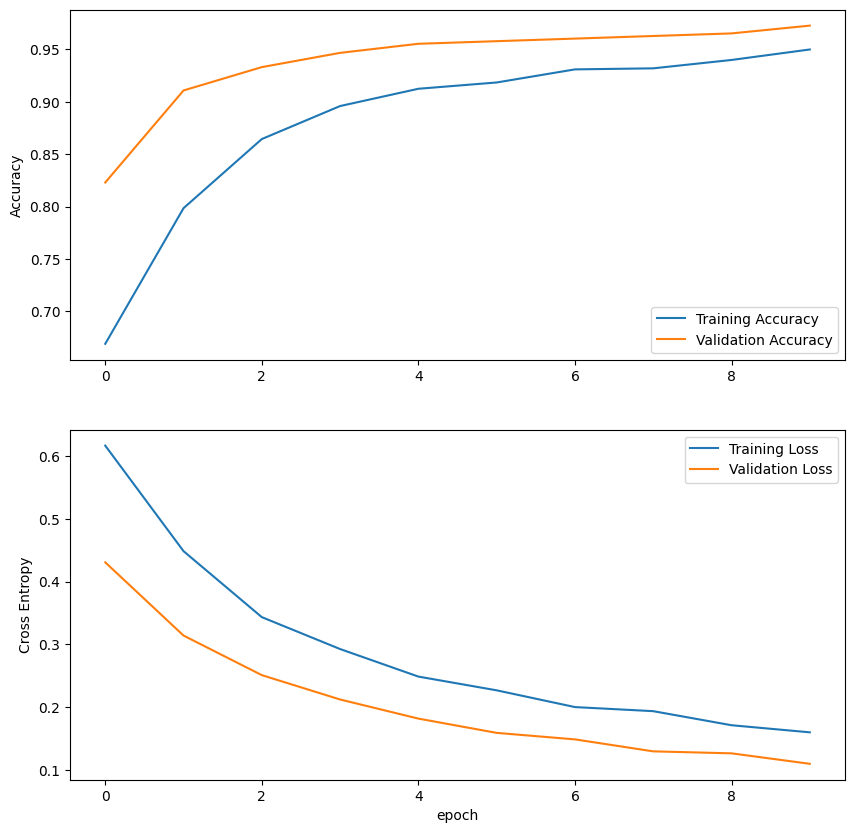

In [23]:
# plottiamo l'andamento della loss e dell'accuracy
plt.figure(figsize=(10, 10), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(hystory.history['accuracy'], label='Training Accuracy')
plt.plot(hystory.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(hystory.history['loss'], label='Training Loss')
plt.plot(hystory.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.show()